# 1. Libaries

In [16]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix, precision_recall_curve, f1_score
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score

from models.EFM import Ethereum_Fraud_Model
from models.RF import Random_Forest_Model
from models.DBSCAN import DBSCAN_Model
from models.SVM import SVM_Model
from models.LR import Logistic_Regression_Model
from models.GMM import GMM_Model
from models.PCA import PCA_Transformer

from config import *
from utils.cleaner import *

# 2. Data Reading

In [17]:
efm = Ethereum_Fraud_Model()
print(efm.df.shape)
display(efm.df.head())

(9841, 50)


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
4827,1895,0x8028914b41d6f40f8eb360efeae17a7e807389ba,0,0.00,1516.02,200114.00,0,132,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,None,OmiseGO
2272,2273,0x3b53ac518414c5104b4695675d8a32c200d56073,0,0.00,214.21,909754.48,0,4247,1,932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,None,Bilian
3258,326,0x5611bbccdefbb4028b94d82fa6ec48de8c65c03b,0,0.00,22101.70,198915.27,0,9,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,None,DATAcoin
863,864,0x1528e24fb07dfb80e5144d2f479df10c9d26088f,0,0.00,50279.59,201118.35,0,4,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3982,1050,0x6a212ca2490071b97430cc34131f2d9ea300c043,0,2.12,0.00,6.35,3,2,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


# 3. Data Exploration

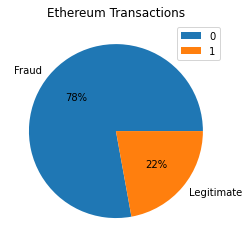

In [18]:
df = efm.df.copy()
flag_counts = df['FLAG'].value_counts()

plt.pie(flag_counts, labels={'Fraud', 'Legitimate'}, autopct='%.0f%%')
plt.title('Ethereum Transactions')
plt.legend(flag_counts.keys().tolist())
plt.show()

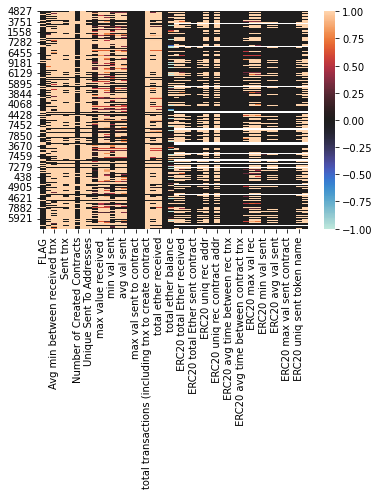

In [19]:
df.drop(efm.filtered_colns, axis=1, inplace=True)
ax = sns.heatmap(df, center=0, vmin=-1, vmax=1)

In [20]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:10]

In [21]:
test = get_top_abs_correlations(df)
print(test)

max val sent to contract       total ether sent contracts    1.000000
 ERC20 total Ether received     ERC20 max val rec            0.999967
 ERC20 max val sent             ERC20 avg val sent           0.999952
 ERC20 min val sent             ERC20 avg val sent           0.999785
                                ERC20 max val sent           0.999729
 ERC20 total ether sent         ERC20 max val sent           0.999649
 ERC20 uniq rec contract addr   ERC20 uniq rec token name    0.999642
 ERC20 total ether sent         ERC20 avg val sent           0.999566
                                ERC20 min val sent           0.999311
avg value sent to contract     total ether sent contracts    0.949608
dtype: float64


['total ether sent contracts', ' ERC20 max val rec', ' ERC20 min val sent', ' ERC20 max val sent', ' ERC20 avg val sent', ' ERC20 uniq rec token name']
(46, 46)
(46, 46)


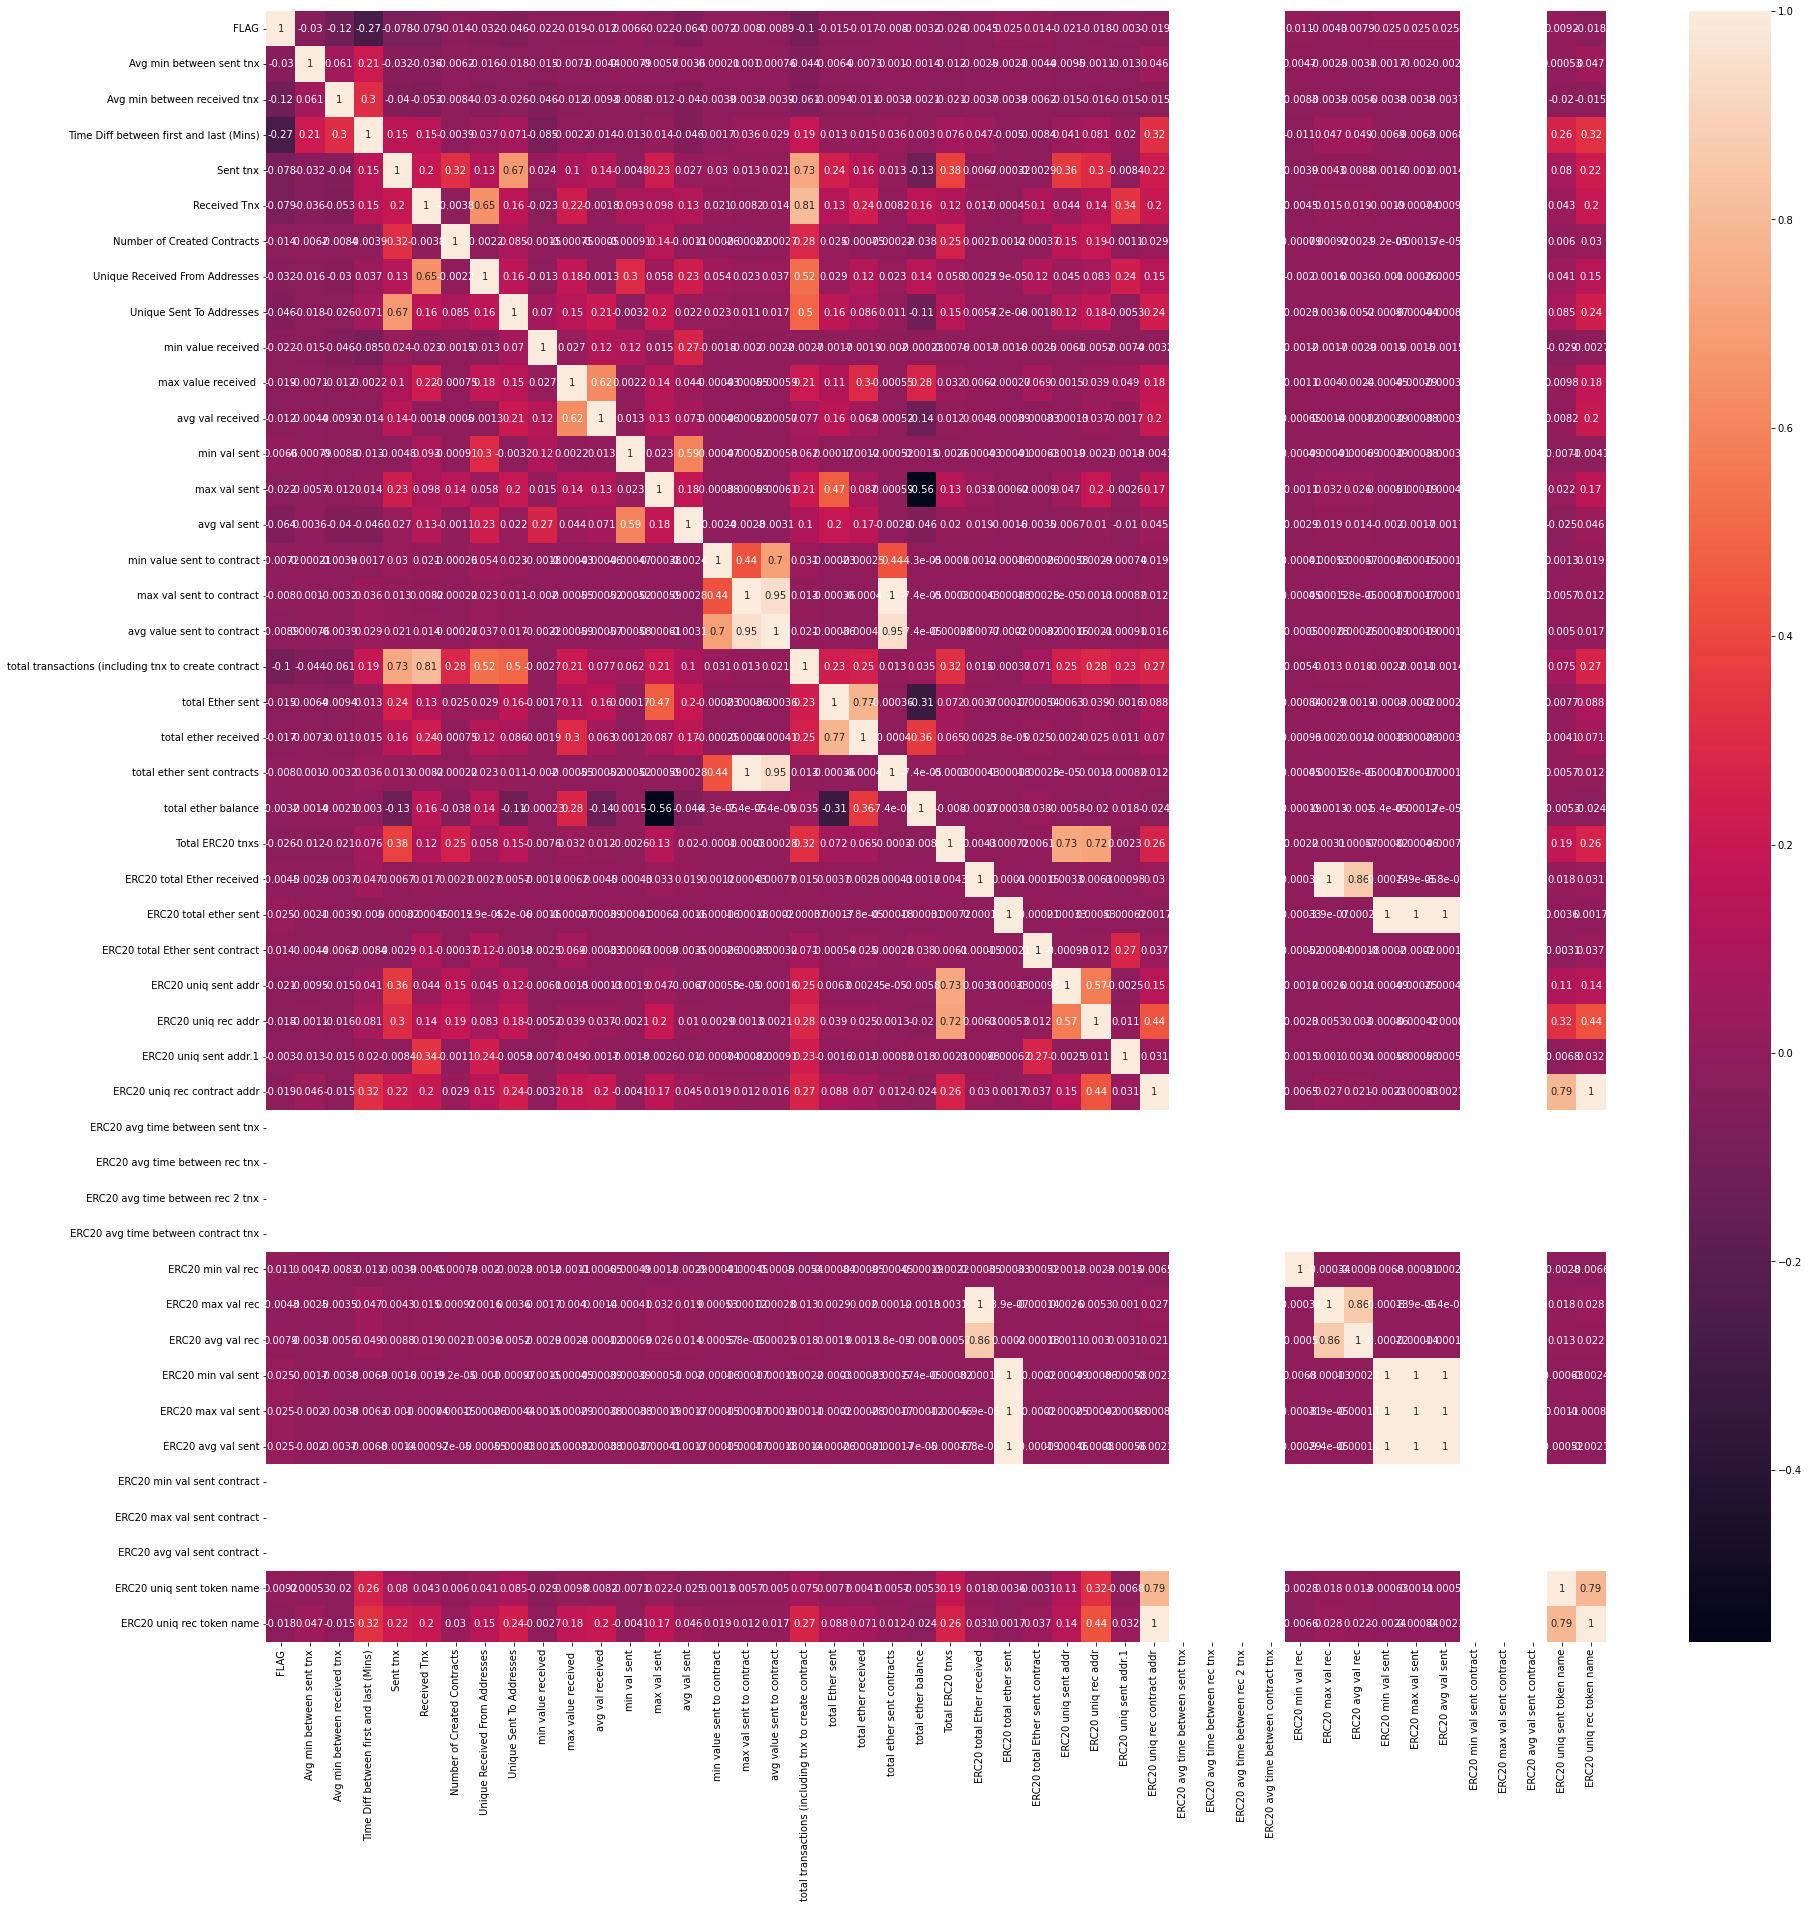

In [22]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#with sns.axes_style('white'):
#    fig, ax = plt.subplots(figsize=(18,10))
#    sns.heatmap(corr_matrix, annot=False, cmap='CMRmap', center=0, square=True)
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(),annot=True)
# Find features with correlation greater than 0.95
corr_colns = [column for column in upper.columns if any(upper[column] >0.95)]
print(corr_colns)
print(upper.shape)
df.drop(corr_colns, axis=1, inplace=True)
print(upper.shape)

# Add Box Plot Analysis

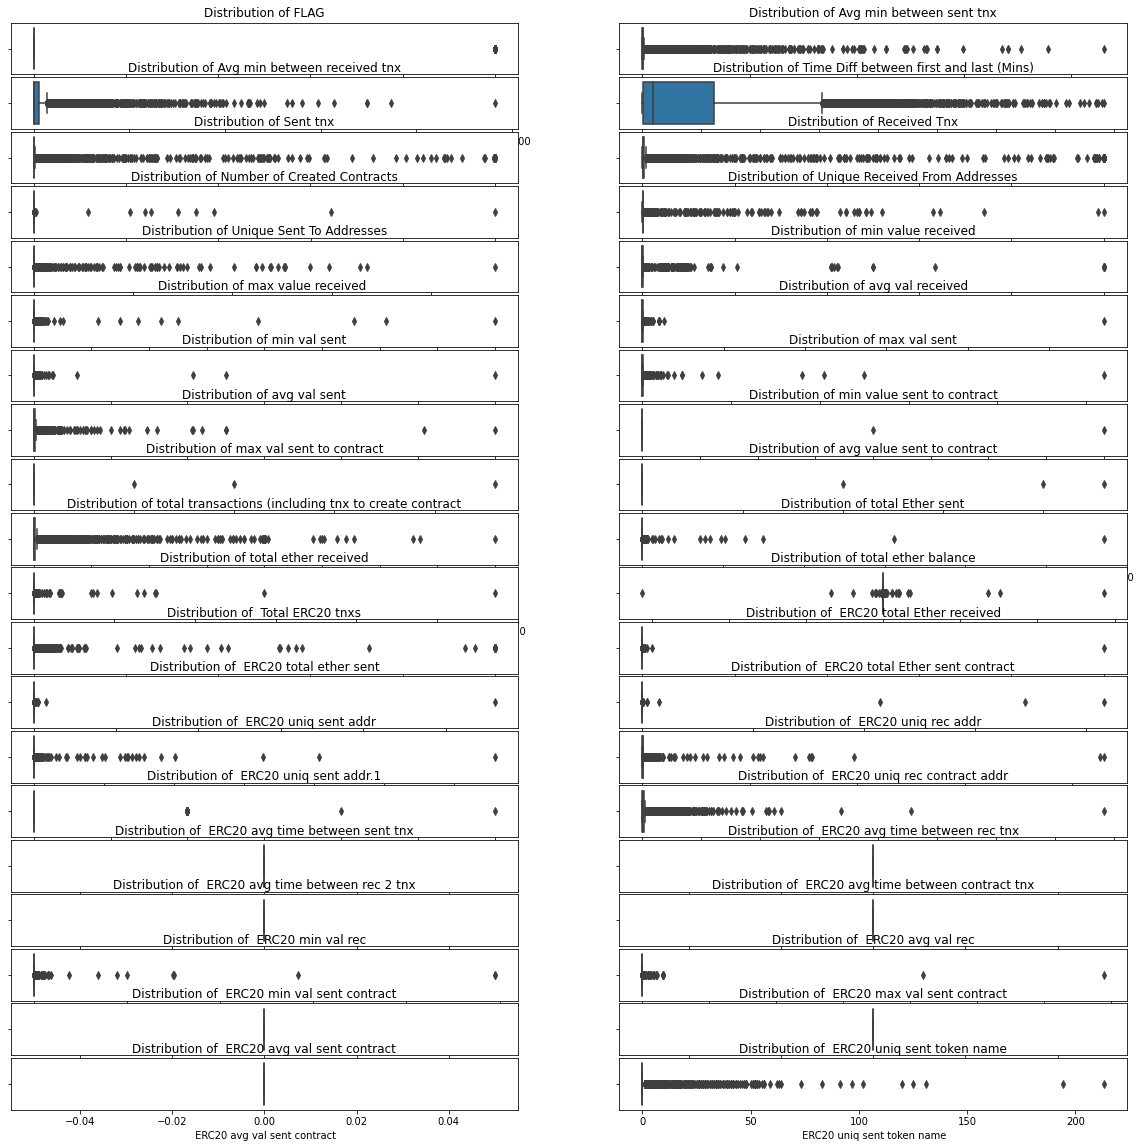

In [23]:
columns = df.columns
fig, axes = plt.subplots(20, 2, figsize=(20, 20), constrained_layout =True)
plt.subplots_adjust(wspace = 0.2, hspace=0.05)
#plt.suptitle("Distribution of features",y=0.95, size=18, weight='bold')
k = 0
for i in range(20):
    for j in range(2):
        sns.boxplot(ax = axes[i,j], data=df, x=columns[k]).set_title(f'Distribution of {columns[k]}')
        k = k+1
#fig.tight_layout()
plt.show()
    #plt.figure()
    #df.boxplot([column], by="FLAG", layout=(1,3),grid=True)

# 4. Data Cleaning

In [24]:
print_nan_data(df)

FLAG                                                    0.000000
Avg min between sent tnx                                0.000000
Avg min between received tnx                            0.000000
Time Diff between first and last (Mins)                 0.000000
Sent tnx                                                0.000000
Received Tnx                                            0.000000
Number of Created Contracts                             0.000000
Unique Received From Addresses                          0.000000
Unique Sent To Addresses                                0.000000
min value received                                      0.000000
max value received                                      0.000000
avg val received                                        0.000000
min val sent                                            0.000000
max val sent                                            0.000000
avg val sent                                            0.000000
min value sent to contrac

In [25]:
# Drop missing data observations/rows
df_clean = remove_nan_rows(df)
print_nan_data(df_clean)

FLAG                                                    0.0
Avg min between sent tnx                                0.0
Avg min between received tnx                            0.0
Time Diff between first and last (Mins)                 0.0
Sent tnx                                                0.0
Received Tnx                                            0.0
Number of Created Contracts                             0.0
Unique Received From Addresses                          0.0
Unique Sent To Addresses                                0.0
min value received                                      0.0
max value received                                      0.0
avg val received                                        0.0
min val sent                                            0.0
max val sent                                            0.0
avg val sent                                            0.0
min value sent to contract                              0.0
max val sent to contract                

In [26]:
# Drop missing data features/columns
# df_clean = remove_nan_columns(df)

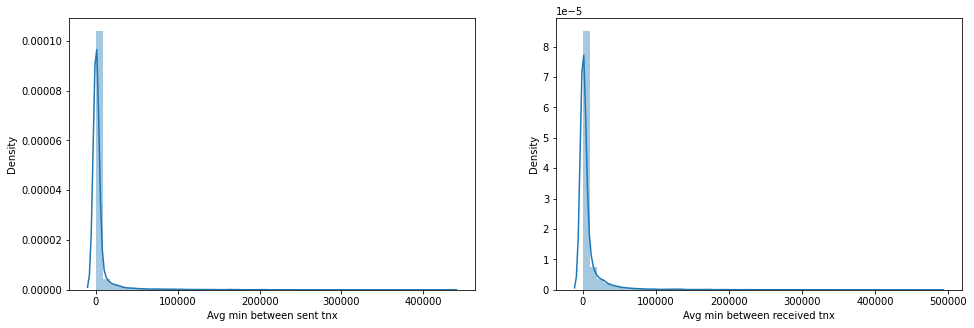

In [27]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['Avg min between sent tnx'])
plt.subplot(1,2,2)
sns.distplot(df['Avg min between received tnx'])
plt.show()

# 5. Data Preparation

In [28]:
# Normalizae Data
df_norm = df_clean.copy()

# apply normalization techniques
for column in df_norm.columns:
    if column == TARGET:
        continue
    print(column, df_norm[column].max(), df_norm[column].min(), (df_norm[column].max() - df_norm[column].min()))
    df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())

df_norm.dropna(inplace=True, axis=1)
print(df_norm)

Avg min between sent tnx 430287.67 0.0 430287.67
Avg min between received tnx 482175.49 0.0 482175.49
Time Diff between first and last (Mins) 1954860.95 0.0 1954860.95
Sent tnx 10000 0 10000
Received Tnx 10000 0 10000
Number of Created Contracts 9995 0 9995
Unique Received From Addresses 9999 0 9999
Unique Sent To Addresses 9287 0 9287
min value received 10000.0 0.0 10000.0
max value received  800000.0 0.0 800000.0
avg val received 283618.8316 0.0 283618.8316
min val sent 12000.0 0.0 12000.0
max val sent 520000.0 0.0 520000.0
avg val sent 12000.0 0.0 12000.0
min value sent to contract 0.02 0.0 0.02
max val sent to contract 0.046029 0.0 0.046029
avg value sent to contract 0.023014 0.0 0.023014
total transactions (including tnx to create contract 19995 0 19995
total Ether sent 28580960.89 0.0 28580960.89
total ether received 28581590.07 0.0 28581590.07
total ether balance 14288636.26 -15605352.04 29893988.299999997
 Total ERC20 tnxs 10001.0 0.0 10001.0
 ERC20 total Ether received 1000020

In [29]:
display(df_norm)

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 avg val rec,ERC20 uniq sent token name
4827,0,0.000000,0.003144,0.102367,0.0000,0.0132,0.0001,0.000300,0.000000,0.000000,...,3.964585e-12,0.000000e+00,0.000000e+00,0.000000,0.000466,0.000000,0.002558,4.527121e-07,1.149724e-10,0.000000
2272,0,0.000000,0.000444,0.465381,0.0000,0.4247,0.0001,0.093209,0.000000,0.000000,...,1.999960e-18,0.000000e+00,4.807692e-12,0.000000,0.000233,0.333333,0.001279,0.000000e+00,5.799855e-17,0.000000
3258,0,0.000000,0.045837,0.101754,0.0000,0.0009,0.0001,0.000300,0.000000,0.000000,...,5.504618e-13,0.000000e+00,0.000000e+00,0.000000,0.000233,0.000000,0.001279,5.560333e-07,3.192664e-11,0.000000
863,0,0.000000,0.104277,0.102881,0.0000,0.0004,0.0001,0.000300,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
3982,0,0.000005,0.000000,0.000003,0.0003,0.0002,0.0000,0.000200,0.000323,0.045384,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0,0.000378,0.000002,0.000167,0.0002,0.0002,0.0000,0.000200,0.000215,0.004852,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
9367,1,0.047565,0.000204,0.021292,0.0002,0.0007,0.0000,0.000600,0.000108,0.000005,...,9.109818e-28,0.000000e+00,0.000000e+00,0.000000,0.000233,0.000000,0.001279,0.000000e+00,0.000000e+00,0.000000
6102,0,0.000366,0.000000,0.000161,0.0002,0.0001,0.0000,0.000100,0.000215,0.010100,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
3500,0,0.013080,0.004795,0.509960,0.0157,0.0049,0.0000,0.002700,0.012060,0.000000,...,7.021280e-07,2.756422e-06,0.000000e+00,0.003950,0.019334,0.000000,0.131714,0.000000e+00,3.365555e-07,0.150235


(33, 33)


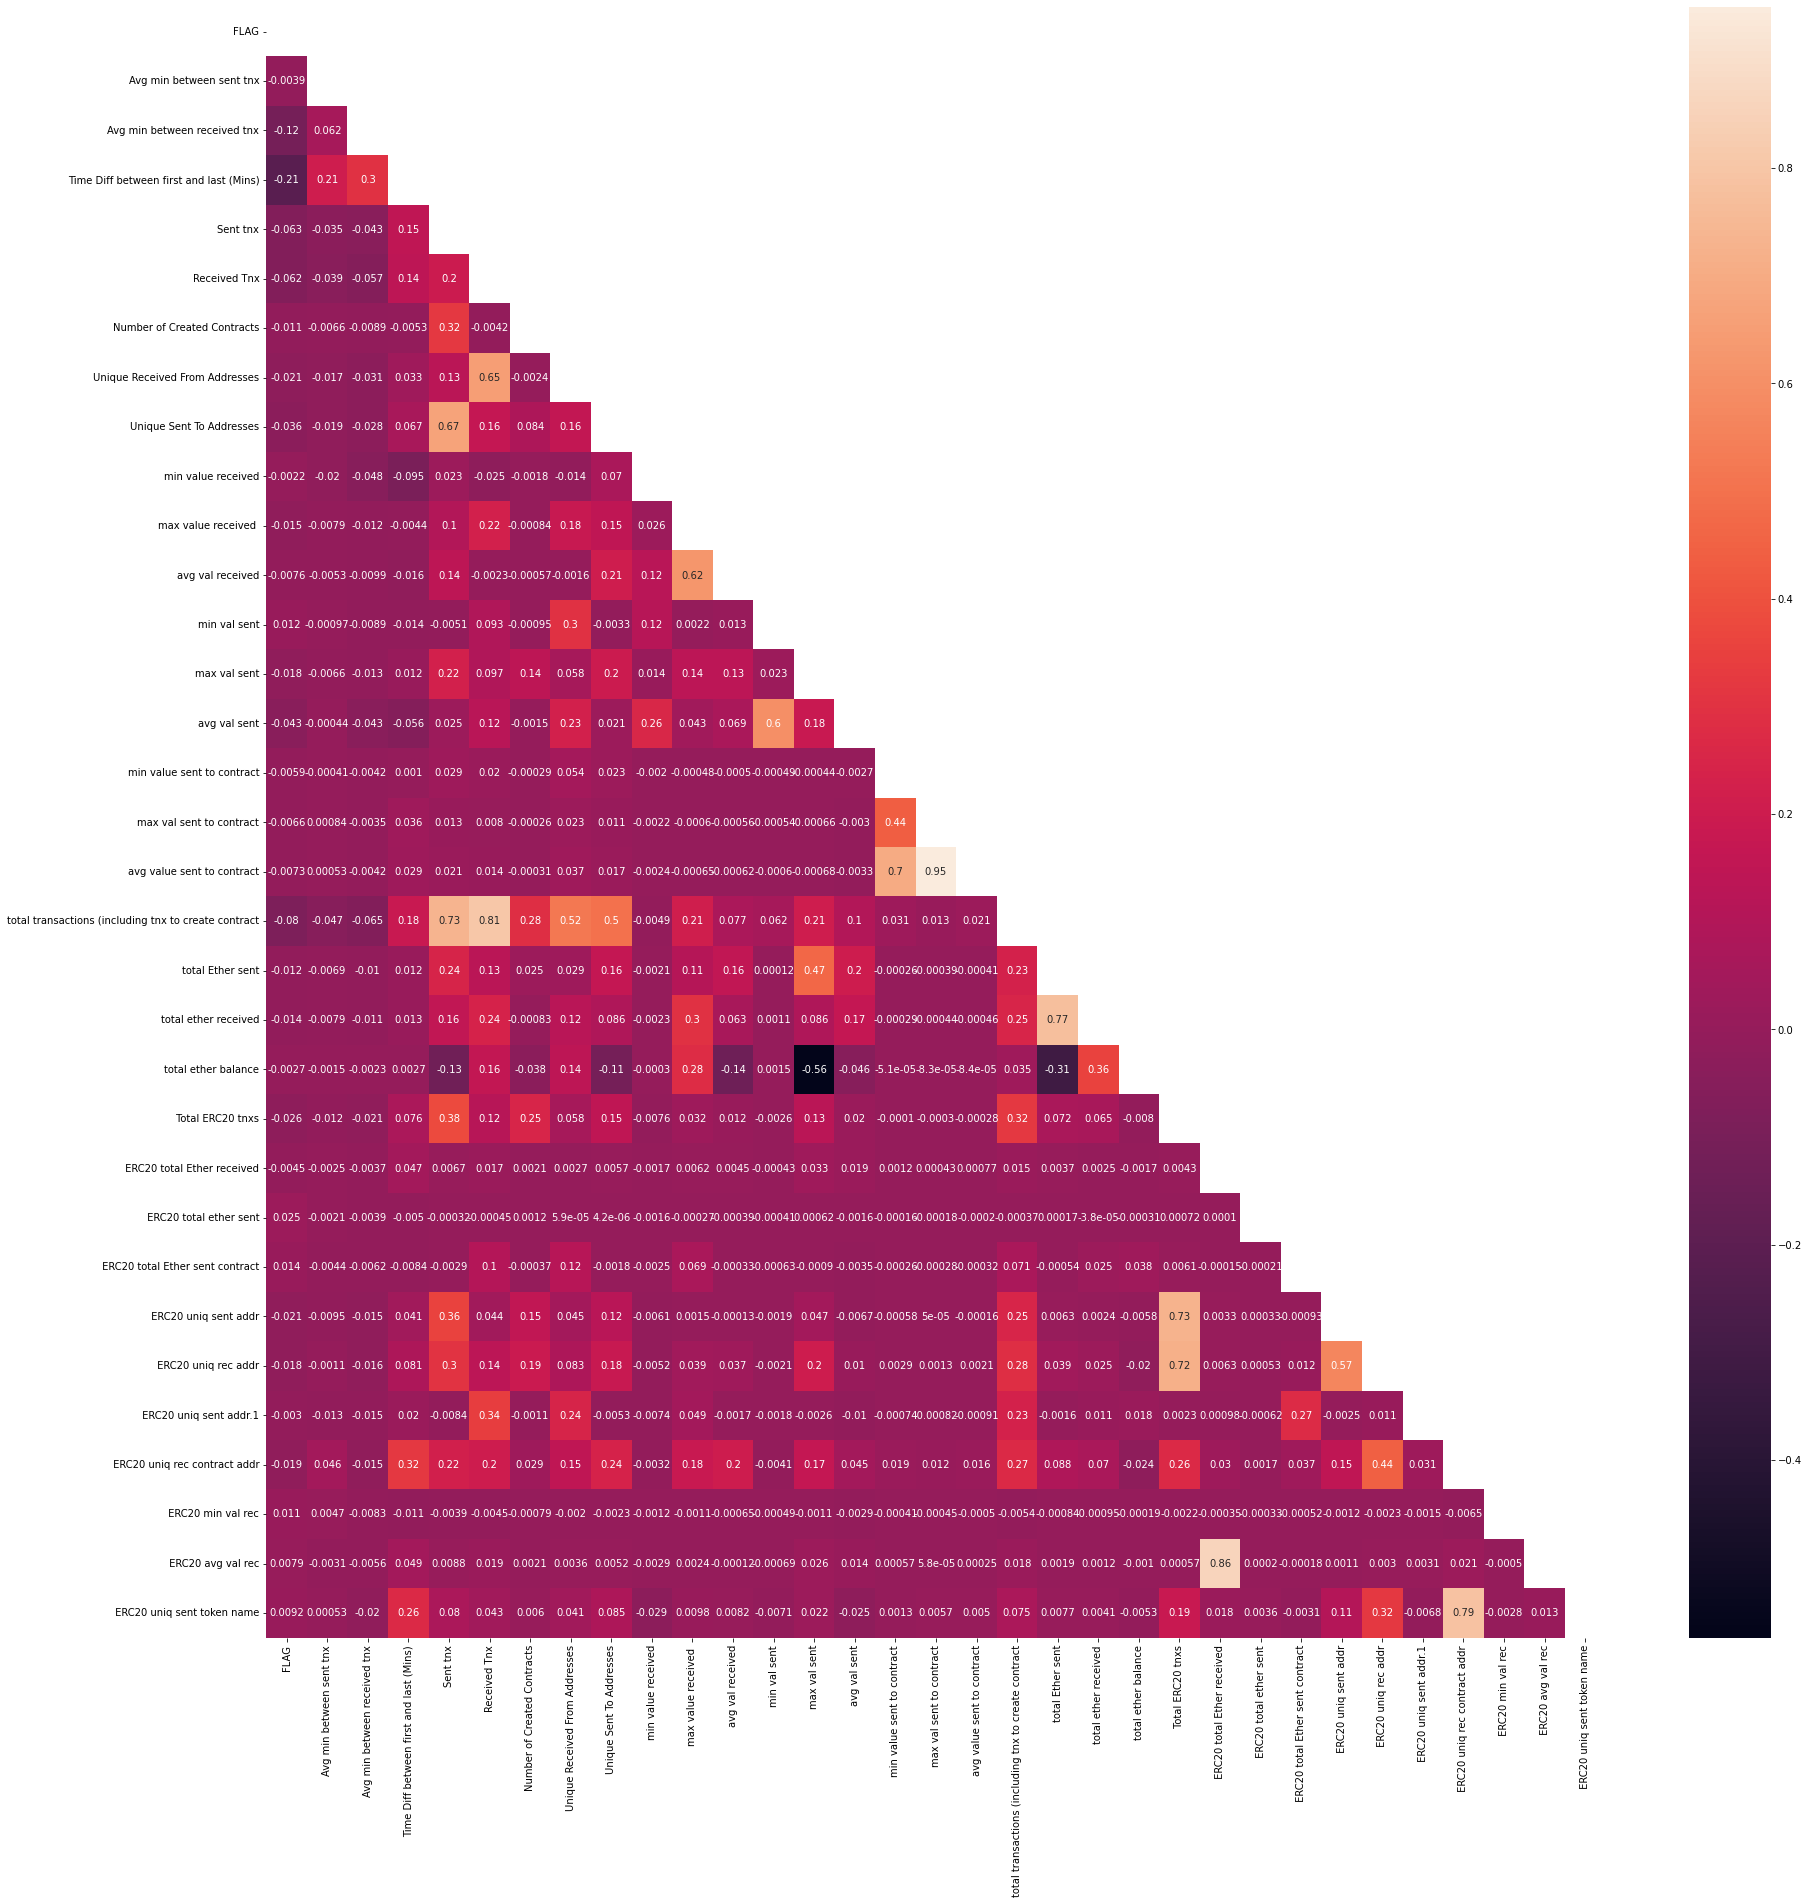

In [34]:
corr_matrix = df_norm.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#with sns.axes_style('white'):
#    fig, ax = plt.subplots(figsize=(18,10))
#    sns.heatmap(corr_matrix, annot=False, cmap='CMRmap', center=0, square=True)
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(30,30))
sns.heatmap(df_norm.corr(),annot=True, mask=mask)
# Find features with correlation greater than 0.95
print(upper.shape)

ValueError: 'label' must be of length 'x'

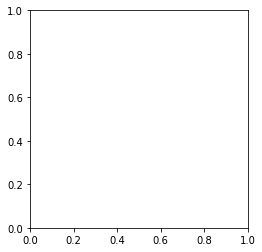

In [24]:
flag_counts = df_norm['FLAG'].value_counts()

plt.pie(flag_counts, labels={'Fraud', 'Legitimate'}, autopct='%.0f%%')
plt.title('Ethereum Transactions')
plt.legend(flag_counts.keys().tolist())
plt.show()

# 6. Sampling

## Method 1. SMOTE Sampling

In [ ]:
from utils.sampling import smote

df_smote = df_norm.copy()

X = df_smote.drop(TARGET, axis=1)
y = df_smote[TARGET]
X_res, y_res = smote(X, y, verbose=True)
df_smote = pd.concat([X_res, y_res], axis=1)
display(df_smote.head())

## Method 2. 3-Way cross validation

# 7. Modeling

## Model 1. Supervised: Random Forest

In [ ]:
df_rfm = df_smote.copy()
rfm = Random_Forest_Model(df_rfm)
rfm.set_max_depth(100)
efm.add_model(rfm)
efm.run_model(model_name='RandomForest')

## Model 2. Supervised: Logistic Regression

In [ ]:
df_lr = df_smote.copy()
df_lr = shuffle(df_lr)
lr = Logistic_Regression_Model(df_lr)
lr.run()

## Model 3. Supervised: Support Vector Machine (SVM)

In [ ]:
from sklearn import svm

df_svm = df_smote.copy()
svm_model = SVM_Model(df_svm)
svm_model.run()

## Model 3. Unsupervised: GMM

In [ ]:
# Trying Standardizing data to get better result with 

from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec

gmm_df = df_norm.copy().drop(TARGET_FEATURE, axis=1)

# Standardization
scale= StandardScaler()
gmm_df = pd.DataFrame(scale.fit_transform(gmm_df), columns=gmm_df.columns)
gmm_df[TARGET_FEATURE] = df_norm[TARGET_FEATURE]

print(df_norm.shape)
print(gmm_df.shape)

# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

features = ['Avg min between sent tnx', 'Avg min between received tnx', 'Sent tnx', 'Received Tnx']

nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(gmm_df[feat][df.FLAG==1], bins=30)
    sns.distplot(gmm_df[feat][df.FLAG==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

print(gmm_df['Avg min between sent tnx'].min())
print(gmm_df['Avg min between sent tnx'].max())

'''
print(gmm_df[feature1].mean())
print(gmm_df[feature1].std())

ax[0,0].hist(gmm_df[feature1], bins=100)
ax[0,0].set_title(feature1, fontsize=14)
ax[0,0].set_ylabel('Transactions')

ax[0,1].hist(gmm_df[feature2], bins=100)
ax[0,1].set_title(feature2, fontsize=14)
ax[0,1].set_ylabel('Transactions')

ax[1,0].hist(gmm_df[feature3], bins=100)
ax[1,0].set_title(feature3, fontsize=14)
ax[1,0].set_ylabel('Transactions')

ax[1,1].hist(gmm_df[feature4], bins=100)
ax[1,1].set_title(feature4, fontsize=14)
ax[1,1].set_ylabel('Transactions')
'''

In [ ]:
# GMM
# df_gmm = df_smote.copy()
gmm_model = GMM_Model(gmm_df)
gmm_model.run(verbose=True)
# efm.add_model(gmm_model)
# efm.run_model(model_name='GMM', verbose=True)

## Model 4. Unsupervised: DBSCAN

In [ ]:
# DBSCAN Model
df_dbscan = df_smote.copy()
dbscan_model = DBSCAN_Model(df_dbscan)
efm.add_model(dbscan_model)
efm.run_model(model_name='DBSCAN')

# 8. Model Evaluation (by Kenny)

### -------------------- Functions Delarations --------------------

In [ ]:
# Helper: compute corresponding f1-score given thresholds
def compute_f1(y_test, y_pred, thresholds):
    scores = []
    for th in thresholds:
        th_y_pred = y_pred.copy()
        
        th_y_pred[th_y_pred >= th] = 0
        th_y_pred[th_y_pred < th] = 1
        scores.append(f1_score(y_test, th_y_pred))
    return scores


def plot_ROC(y_test, y_pred, plt_config, f1=False):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    scores = []
    if f1:
        scores = compute_f1(y_test, y_pred, thresholds)

    plt.figure(figsize=plt_config['figsize'])
    plt.title('ROC for ' + plt_config['model'])
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0,1], [0,1], 'y--')
    if f1:
        plt.plot(thresholds, scores, 'r')
    plt.ylabel('True Positive Rate / Score')
    plt.xlabel('False Positive Rate / Threshold')
    plt.legend(['ROC', 'Perfect Classifier', 'F1'])
    plt.show()


def plot_PRC(y_test, y_pred, plt_config, f1=False):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

    scores = []
    if f1:
        scores = compute_f1(y_test, y_pred, thresholds)

    plt.figure(figsize=plt_config['figsize'])
    plt.title('PRC for ' + plt_config['model'])
    plt.plot(recall, precision, 'b')
    if f1:
        plt.plot(thresholds, scores, 'r')
    plt.ylabel('Precision / Score')
    plt.xlabel('Recall / Threshold')
    plt.legend(['PRC', 'F1'])
    plt.show()


## Metric 1. ROC w/ F1

In [ ]:
# Prepare parameters for ROC

# Uncomment the following when you have data ready

"""
# Get probablistic predictions using a trained model
probs = xgb_c.predict_proba(norm_test_f)
pred = probs[:, 1]

# Customize plot
plt_config = {
    'figsize': (12, 8),
    'model': 'XGB Classifier'
}

# Call the function with your choice of f1 plotting (in the same grapgh)
plot_ROC(y_test, pred, plt_config, f1=True)
"""

## Metric 2. PRC w/ F1

In [ ]:
# Prepare parameters for PRC

# Uncomment the following when you have data ready

"""
# Get probablistic predictions using a trained model
probs = xgb_c.predict_proba(norm_test_f)
pred = probs[:, 1]

# Customize plot
plt_config = {
    'figsize': (12, 8),
    'model': 'XGB Classifier'
}

# Call the function with your choice of f1 plotting (in the same grapgh)
plot_PRC(y_test, pred, plt_config, f1=True)
"""